# FNN Linus Etemi

## Imports


In [122]:
TYPE = 'GPU'

if TYPE == 'CPU':
    import numpy as np
else:
    import cupy as np
    
import scipy.special
import math
import matplotlib
import matplotlib.pyplot as matplot
import pickle

from ray import tune
from csv import writer


## Config

In [123]:
#hiddennodes_start = 800
#hiddennodes_stop = 800
#hiddennodes_step = 100

#learningrate_start = 0.08
#learningrate_stop = 0.08
#learningrate_step = 0.01

#epochs_start = 1
#epochs_stop = 2
#epochs_step = 0

outputnodes = 10
hiddennodes = 900
learningrate = 0.05
inputnodes = 784
epochs= 23


## Neuronales Netz 

In [124]:
class neuralNetwork:
    def __init__(self, innodes, outnodes, hidnodes, learningrate, epochs):
        self.inodes = innodes
        self.onodes = outnodes
        self.hnodes = hidnodes
        self.lr = learningrate
        self.epo = epochs
        self.wih = ((np.random.rand(self.hnodes,self.inodes)*2)-1)
        self.who = ((np.random.rand(self.onodes,self.hnodes)*2)-1)
        pass
    
    def activation_function(self, z: int) -> classmethod:
        return 1 / (1 + np.exp(-z))

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)

        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors) 
        self.who += self.lr * np.dot( (output_errors*final_outputs*(1.0-final_outputs)), np.transpose(hidden_outputs)) 
        self.wih += self.lr * np.dot( (hidden_errors*hidden_outputs*(1.0-hidden_outputs)), np.transpose(inputs)) 
        pass

    def query(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    

    

In [125]:
def clear_content(fname: str) -> None:
    file = open(fname, "w+")
    file.close

## Train_Network

In [126]:
def train_network(n, epo): 
        #clear_content('mnist_second_train.csv')
        training_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()

        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')

                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n.train(inputs, targets)

                pass
            pass

## Train_Network 2


In [127]:
def train_network2(n2, epo, counter):  
        training_data_file = open('./MNISTData_2nd/mnist_second_train.csv', 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()
        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n2.train(inputs, targets)
                pass
            pass
        pickle.dump(n2, open('./MNISTNet_2nd/neural_network_'+str(counter)+'.obj', 'wb'))

## Test_Network1 & Train_Network2

In [128]:
def test_network(n):

    test_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    array_data_all = []
    scorecard_N_plus = []    
    scorecard_N_1R = []
    n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)   
    counter = 0

    for i in range(100):
        array_data_all.append([])
        scorecard_N_plus.append([])
        scorecard_N_1R.append([])

    for threshold in range(100):
        clear_content('./MNISTData_2nd/mnist_second_train.csv')
        for record in test_data_list:
            all_values = record.rstrip('\n').split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
            outputs = n.query(inputs)
            label_max = outputs[np.argmax(outputs)]
            label = np.argmax(outputs)
            if(label_max > (threshold/100)):
                scorecard_N_plus[threshold].append(1)
                if(label == correct_label):
                    scorecard_N_1R[threshold].append(1)
                else:
                    scorecard_N_1R[threshold].append(0)
            else:
                scorecard_N_plus[threshold].append(0)
                append_list_as_row('./MNISTData_2nd/mnist_second_train.csv', all_values)
            
        train_network2(n2, epochs, counter)
        counter += 1


## Gesamttest


In [129]:
def test_network2(n1):
    test_data_file = open("./MNISTData_red/mnist_test_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()

    P = []
    Q = []
    X = []
    # for i in range(100):
    #     N_1R.append([])
    #     N_plus.append([])
    #     N_2R.append([])


    Ngesamt = 8215


    for threshold in range (0,100):
        n2 = pickle.load(open('./MNISTNet_2nd/neural_network_'+str(threshold)+'.obj', 'rb'))
        N_plus = []
        N_1R= []
        N_2R = []

        for record in test_data_list:
            all_values = record.split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01

            outputs_n1 = n1.query(inputs)
            label_n1 = np.argmax(outputs_n1)
            label_n1_max = outputs_n1[np.argmax(outputs_n1)]

            if(label_n1_max > (threshold/100)):
                N_plus.append(1)
                if(label_n1 == correct_label):
                    N_1R.append(1)
                    
            else:
                outputs_n2 = n2.query(inputs)
                label_n2 = np.argmax(outputs_n2)

                if(label_n2 == correct_label):
                    N_2R.append(1)



        P.append(len(N_plus)/Ngesamt)
        Q.append(len(N_1R)/len(N_plus))
        X.append((len(N_1R)+len(N_2R))/Ngesamt)





    return P, Q, X

## CSV Writer und Grid Search

In [130]:
def append_list_as_row(fname,list_of_elem):
    with open(fname, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)

In [131]:
#learningrate_i = learningrate_start
#hiddennodes_i = hiddennodes_start
#epochs_i = epochs_start


#while epochs_i <= epochs_stop:
#    while hiddennodes_i <= hiddennodes_stop:
#        while learningrate_i <= learningrate_stop:
#            intermediate_score = neuralNetwork(784,10,hiddennodes_i,learningrate_i,epochs_i).test_train()
#            print('Epoch [{:02d}/{:02d}]     | Hidden_Nodes [{:04d}/{:04d}]     | Learning_Rate [{:.2f}/{:.2f}]     | Performance: {:.5f}'.format(epochs_i,epochs_stop,hiddennodes_i,hiddennodes_stop,learningrate_i,learningrate_stop,intermediate_score))
#            append_list_as_row([784,10,hiddennodes_i,learningrate_i,epochs_i,intermediate_score])
#            learningrate_i += learningrate_step 
#        learningrate_i = learningrate_start    
#        hiddennodes_i += hiddennodes_step
#        print("========================================================")
#    hiddennodes_i = hiddennodes_start
#    epochs_i += epochs_step
#    print("========================================================")

## Scoring und Aufruf von Beiden Netzen

In [132]:
#epochs = 23
#n1 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
#train_network(n1, epochs)
#pickle.dump(n1, open('./MNISTNet_1st/neural_network_1.obj', 'wb'))
# n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))
# test_network(n1)

In [133]:
#epochs = 7
intermediate_score_card = []
#n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
#train_network2(n2, epochs)
n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))

P, Q, X = test_network2(n1)
print(P, Q, X)    


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997565429093123, 0.9997565429093123, 0.9995130858186244, 0.9992696287279367, 0.9990261716372489, 0.9986609860012173, 0.9980523432744979, 0.9978088861838101, 0.9975654290931223, 0.9973219720024346, 0.996956786366403, 0.9967133292757152, 0.9963481436396835, 0.9953743152769324, 0.994887401095557, 0.9941570298234936, 0.9933049300060864, 0.9928180158247109, 0.9923311016433354, 0.9920876445526476, 0.9913572732805843, 0.9905051734631771, 0.9898965307364577, 0.9890444309190505, 0.988557516737675, 0.9881923311016433, 0.9872185027388922, 0.986488131466829, 0.9858794887401096, 0.985514303104078, 0.9844187461959829, 0.9836883749239197, 0.9825928180158248, 0.9818624467437614, 0.9813755325623859, 0.9806451612903225, 0.9802799756542909, 0.9799147900182593, 0.979184418746196, 0.9785757760194765, 0.9780888618381011, 0.97711503347535, 0.9760194765672551, 0.9755325623858795, 0.9745587340231284, 0.9737066342057212, 0.972854534388314, 0.9721241631162507, 0.97127206329

## Plotting

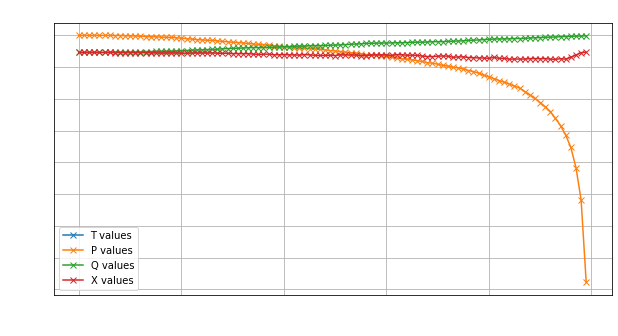

In [135]:
l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
t_values = []

import numpy as np

N = len(t_values)
l2 = np.arange(N)

with matplot.rc_context({'axes.edgecolor': 'black', 'xtick.color':'white','ytick.color':'white'}):
    matplot.subplots(figsize=(10,5))
    matplot.plot(l2, t_values, marker= 'x',label='T values')
    matplot.plot(np.arange(len(P)), P ,marker= 'x', label='P values')
    matplot.plot(np.arange(len(Q)), Q, marker= 'x',label='Q values')
    matplot.plot(np.arange(len(X)), X, marker= 'x',label='X values')

    matplot.grid(True)
    matplot.xlabel("%", fontsize = 12, color = 'white')
    matplot.colorbar
    matplot.ylabel("%", fontsize = 12, color = 'white')
    matplot.legend()
    matplot.title("P & Q & T Values", fontsize = 12, color = 'white')
    matplot.savefig('diagramm.png')
    matplot.show()


